# Programming Assignment: Numerical Optimization for Logistic Regression.

### Name: Nick Benelli


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

x_sparse, y = datasets.load_svmlight_file('diabetes.txt')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.16245785 -0.02097862 -0.1580922  -0.02091155  0.10803989 -0.16290386
   0.09737051  0.0732707 ]]
test std = 
[[1.04225143 1.08208613 1.03888597 0.98161317 1.28500117 0.90073669
  1.20255918 0.97709841]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5874287754926292
Objective value at t=2 is 0.543029130490009
Objective value at t=3 is 0.5187483192627562
Objective value at t=4 is 0.5034446546129732
Objective value at t=5 is 0.49301385097062606
Objective value at t=6 is 0.48555258303636445
Objective value at t=7 is 0.48003751584354165
Objective value at t=8 is 0.47586194466290016
Objective value at t=9 is 0.47264123128473007
Objective value at t=10 is 0.4701195477331615
Objective value at t=11 is 0.46812052823362243
Objective value at t=12 is 0.46651913616238694
Objective value at t=13 is 0.46522469128220717
Objective value at t=14 is 0.4641701718822136
Objective value at t=15 is 0.46330523417120395
Objective value at t=16 is 0.4625915269565722
Objective value at t=17 is 0.4619994718506002
Objective value at t=18 is 0.4615060054544975
Objective value at t=19 is 0.461092967930824
Objective value at t=20 is 0.46074593477267684
Objective value at t=21 is 0.4604533

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5149972575011297
Objective value at epoch t=1 is 0.5080980111578215
Objective value at epoch t=2 is 0.4999724005343301
Objective value at epoch t=3 is 0.49403259571745084
Objective value at epoch t=4 is 0.49280583796316935
Objective value at epoch t=5 is 0.49128694068744555
Objective value at epoch t=6 is 0.48771617756828506
Objective value at epoch t=7 is 0.47906856939684694
Objective value at epoch t=8 is 0.4850984689200537
Objective value at epoch t=9 is 0.47994258691684155
Objective value at epoch t=10 is 0.4711376945414596
Objective value at epoch t=11 is 0.47792899168672165
Objective value at epoch t=12 is 0.4723082363982284
Objective value at epoch t=13 is 0.46961312161595303
Objective value at epoch t=14 is 0.4732231570736397
Objective value at epoch t=15 is 0.4693845600249693
Objective value at epoch t=16 is 0.4701415058386308
Objective value at epoch t=17 is 0.46859722320757397
Objective value at epoch t=18 is 0.4675594867860088
Objective val

# 4. Compare GD with SGD

Plot objective function values against epochs.

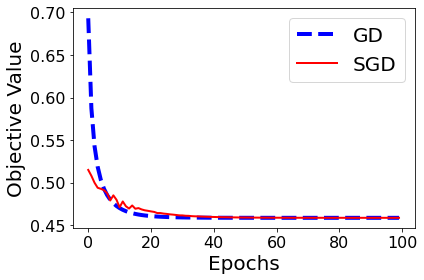

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2140625


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.25


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [17]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    '''
    Multi-batch stochastic objection function and gradient

    Parameters
    ----------
    w : numpy.matrix
        d-by-1 matrx.
    xi : numpy.matrix
        b-by-d matrix.
    yi : numpy.matrix
        b-by-1 matrix.
    lam : float
        regularization parameter.
    b : int
        batch size.

    Returns
    -------
    obj : float
        objection function Q_i().
    g : numpy.matrix
        d-by-1 matrix, gradient of Q_i.

    '''
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    n, d = xi.shape
    yx = numpy.multiply(yi, xi) # n-by-d matrix
    yxw = numpy.dot(yx, w)      # n-by-1 matrix
    
    # calculate objective function Q_i
    loss = numpy.mean( numpy.log( 1 + numpy.exp(-yxw))) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar (regularization term)
    obj = loss + reg # scalar
    
    # calculate mini-batch stochastic gradient dQ_i
    g_loss0 = -yx / (1+ numpy.exp(yxw)) # b-by-d matrix (summation section)
    g_loss = numpy.mean((g_loss0), axis=0).reshape(d,1) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [18]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    '''
    Multi-Batch Stochasitc Gradient Descent

    Parameters
    ----------
    x : numpy.matrix
        n-by-d matrix.
    y : numpy.ndarray
        n-by-1 matrix.
    lam : float
         the regularization parameter.
    b : integer
        the batch size.
    stepsize : float
        stepsize.
    max_epoch : int, optional
        the maximal epochs. The default is 100.
    w : numpy.matrix, optional
        d-by-1 matrix, initialization of w. The default is None.

    Returns
    -------
    w : numpy.ndarray
        the solution weights.
    objvals : numpy.ndarray
         record of each iteration's objective value.

    '''
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
        
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        # create batches from randomization
        num_batches = x_rand.shape[0] // b     # Get number of batches with remainder 
        batch_remainder =  x_rand.shape[0] % b # Remainder value
        # Loop through randomized data and partition batch
        batches = []
        for b_i in range(num_batches):
            start_idx = b_i * b
            end_idx = (b_i + 1) * b
            x_b = x_rand[start_idx:end_idx, :]
            y_b = y_rand[start_idx:end_idx, :]
            batches.append([x_b, y_b])
            
        # If remainder then add final batch smaller than designated size
        if batch_remainder > 0:
            x_b = x_rand[-batch_remainder:, :]
            y_b = y_rand[-batch_remainder:, :]
            batches.append([x_b, y_b])
            
        # Calculate objective value
        objval = 0 # accumulate the objective values
        for batch_i in batches:
            x_i, y_i = batch_i
            batch_size = x_i.shape[0] # batch_size = b (except remainder)
            obj, g = mb_stochastic_objective_gradient(w, x_i, y_i, lam, batch_size)
            objval += obj
            w -= stepsize * g
            
        stepsize *= 0.9
        objval /= (n/b)
        objvals[t] = objval 
        print(f'Objective value at epoch t={str(t)} is {str(objval)}')
    
    return w, objvals

## 6.3. Run MB-SGD

In [19]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5366055345253647
Objective value at epoch t=1 is 0.476720619150821
Objective value at epoch t=2 is 0.4677575809516023
Objective value at epoch t=3 is 0.4647044351852149
Objective value at epoch t=4 is 0.46394997404486205
Objective value at epoch t=5 is 0.4639736246693091
Objective value at epoch t=6 is 0.46295003143670704
Objective value at epoch t=7 is 0.4628430716496584
Objective value at epoch t=8 is 0.46173632894017913
Objective value at epoch t=9 is 0.46210246692222057
Objective value at epoch t=10 is 0.4616508423181626
Objective value at epoch t=11 is 0.46130784373437245
Objective value at epoch t=12 is 0.46085961953319776
Objective value at epoch t=13 is 0.4608033792818741
Objective value at epoch t=14 is 0.4604690559983594
Objective value at epoch t=15 is 0.46040827442582727
Objective value at epoch t=16 is 0.4601673053213807
Objective value at epoch t=17 is 0.4600824181655233
Objective value at epoch t=18 is 0.4598726803761334
Objective value 

In [20]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.6464567351132272
Objective value at epoch t=1 is 0.5796305382467046
Objective value at epoch t=2 is 0.5460952767288939
Objective value at epoch t=3 is 0.5268246115676585
Objective value at epoch t=4 is 0.5146053297093582
Objective value at epoch t=5 is 0.5057569420798924
Objective value at epoch t=6 is 0.4992077374922704
Objective value at epoch t=7 is 0.49462074713515436
Objective value at epoch t=8 is 0.49080066029384406
Objective value at epoch t=9 is 0.48790949770766173
Objective value at epoch t=10 is 0.48549637425276204
Objective value at epoch t=11 is 0.48369109001910715
Objective value at epoch t=12 is 0.4820274774717278
Objective value at epoch t=13 is 0.48065570431735194
Objective value at epoch t=14 is 0.47965844239171285
Objective value at epoch t=15 is 0.4786403394542922
Objective value at epoch t=16 is 0.4778065107869277
Objective value at epoch t=17 is 0.4771513827999094
Objective value at epoch t=18 is 0.47655182243233946
Objective valu

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

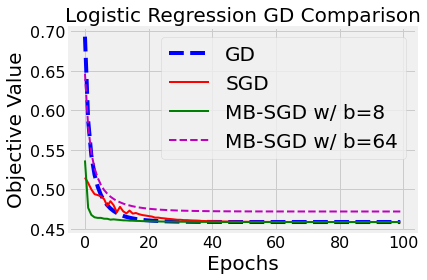

In [26]:
# plot the 4 curves:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4, label='GD')
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2, label='SGD')
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-g', LineWidth=2, label='MB-SGD w/ b=8')
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '--m', LineWidth=2, label='MB-SGD w/ b=64')

plt.title('Logistic Regression GD Comparison', FontSize=20)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_mbsgd.pdf', format='pdf', dpi=1200)    

### Discussion
From the graph, it appears mini-batch gradient descent appears to converge the fastest. The batch size of 8 is the optimal size. Convergence actually slows down when the batch size gets too large. 